# Hotel Price Prediction using Neural Networks

## Importing the libraries

In [27]:
import os, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

MODELS_DIR = pathlib.Path('./models/HotelPricePrediction/')
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing the train and test data

### Splitting the targets from train and testdata

In [28]:
train_data = pd.read_csv('./data/trainingset.csv')
train_targets = train_data['ADR']
train_data.drop(columns=['ADR'], inplace=True)

test_data = pd.read_csv('./data/testset.csv')
test_targets = test_data['ADR']
test_data.drop(columns=['ADR'], inplace=True)


In [29]:
train_data.shape, test_data.shape

((40060, 27), (79330, 27))

### Replace the missing values with the mean of the column

In [30]:
train_data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
DaysInWaitingList                0
CustomerType                     0
RequiredCarParkingSpaces         0
TotalOfSpecialRequests           0
ReservationStatus                0
dtype: int64

In [31]:
train_data['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: Country, Length: 125, dtype: int64

In [32]:
train_data['Country'][train_data['Country'].isna()]

30       NaN
4127     NaN
7092     NaN
7860     NaN
8779     NaN
        ... 
26473    NaN
28460    NaN
31085    NaN
31594    NaN
33087    NaN
Name: Country, Length: 464, dtype: object

In [33]:
train_data['Country'].fillna('PRT', inplace=True)

In [34]:
train_data.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64

In [35]:
test_data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
DaysInWaitingList               0
CustomerType                    0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationStatus               0
dtype: int64

In [36]:
test_data['Children'].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [37]:
test_data['Country'].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [38]:
test_data['Children'].fillna(0, inplace=True)
test_data['Country'].fillna('PRT', inplace=True)

### Encoding the categorical data on training set

In [39]:
train_data.dtypes

IsCanceled                      int64
LeadTime                        int64
ArrivalDateYear                 int64
ArrivalDateMonth               object
ArrivalDateWeekNumber           int64
ArrivalDateDayOfMonth           int64
StaysInWeekendNights            int64
StaysInWeekNights               int64
Adults                          int64
Children                        int64
Babies                          int64
Meal                           object
Country                        object
MarketSegment                  object
DistributionChannel            object
IsRepeatedGuest                 int64
PreviousCancellations           int64
PreviousBookingsNotCanceled     int64
ReservedRoomType               object
AssignedRoomType               object
BookingChanges                  int64
DepositType                    object
DaysInWaitingList               int64
CustomerType                   object
RequiredCarParkingSpaces        int64
TotalOfSpecialRequests          int64
ReservationS

In [40]:
categorical_columns = train_data.select_dtypes(include=['object']).columns

In [41]:
# train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
# test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)


encoders_list = {col: OneHotEncoder() for col in categorical_columns}

for col in categorical_columns:
    enocded_column = encoders_list[col].fit_transform(
        train_data[[col]])
    train_data = pd.concat([train_data, pd.DataFrame(
        enocded_column.toarray(),
        columns=encoders_list[col].categories_)], axis=1)

    train_data.drop(columns=[col], inplace=True)

#     test_data = pd.concat([test_data, pd.DataFrame(encoders_list[i].transform(
#         test_data[[categorical_columns[i]]]).toarray(),
#         columns=encoders_list[i].categories_)], axis=1)

#     test_data.drop(columns=[col], inplace=True)


In [42]:
train_data.shape

(40060, 200)

### Converting the data and targets into tensors

In [ ]:
train_data = tf.convert_to_tensor(train_data.values,
                                        dtype=tf.float64)
train_targets = tf.convert_to_tensor(train_targets.values,
                                     dtype=tf.float64)


2022-12-29 13:10:23.168113: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 13:10:23.170873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:10:23.171541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-29 13:10:23.172053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0

In [ ]:
train_data.shape

TensorShape([40060, 200])

In [ ]:
train_targets.shape

TensorShape([40060])

In [ ]:
train_data.device, train_targets.device

('/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [ ]:
train_data.dtype, train_targets.dtype

(tf.float64, tf.float64)

### Standardization of train_data

In [ ]:
mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std


In [ ]:
train_data[0:4]

<tf.Tensor: shape=(4, 200), dtype=float64, numpy=
array([[-6.19950749e-01,  2.56284748e+00, -1.55251861e+00,
        -1.00579098e-02, -1.66838310e+00, -1.03660697e+00,
        -1.27117116e+00,  1.90527960e-01, -2.89049799e-01,
        -1.16845074e-01, -2.15510567e-01, -7.61909388e-02,
        -1.46171447e-01,  3.73281232e+00, -7.10451956e-02,
        -3.93359247e-01, -7.61463993e-01, -3.14657956e-01,
        -3.73052965e-01, -2.66044036e-01, -2.89762735e-01,
        -2.40651662e-01,  2.78569807e+00, -2.86816923e-01,
        -3.01396380e-01, -3.12256590e-01, -2.54507774e-01,
        -3.12063968e-01, -2.90015714e-01,  5.78887567e-01,
        -1.38502065e-01, -5.01325786e-01, -4.63831695e-02,
        -1.73373494e-01, -2.44838822e-02, -8.65409019e-03,
        -1.11726613e-02, -1.65729761e-02, -3.77477567e-02,
        -7.06594686e-03, -4.66526432e-02, -7.25931237e-02,
        -8.65409019e-03, -4.99631657e-03, -1.06347093e-01,
        -1.11726613e-02, -4.99631657e-03, -4.99631657e-03,
      

## Designing The Neural Network Model

### Multi Layer Perceptron Archtiecture

In [ ]:
from tensorflow.keras import models, layers
from tensorflow import keras

inputs = keras.Input(shape=(train_data.shape[1],))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 32)                6432      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0     

### Compiling the model

In [ ]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

### Training the model with differnet number of epochs

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_extraction.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data, train_targets, validation_split=0.2, epochs=30,
                    batch_size=64, callbacks=callbacks)


In [ ]:
import matplotlib.pyplot as plt


def plot_history(history):
    """Plot training and validation MSE loss and MAE metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title('Training and validation loss')

    epochs = range(1, len(history.history['mae']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss(MSE)')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss(MSE)')
    plt.title('Training and validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(MSE)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

    plt.show()


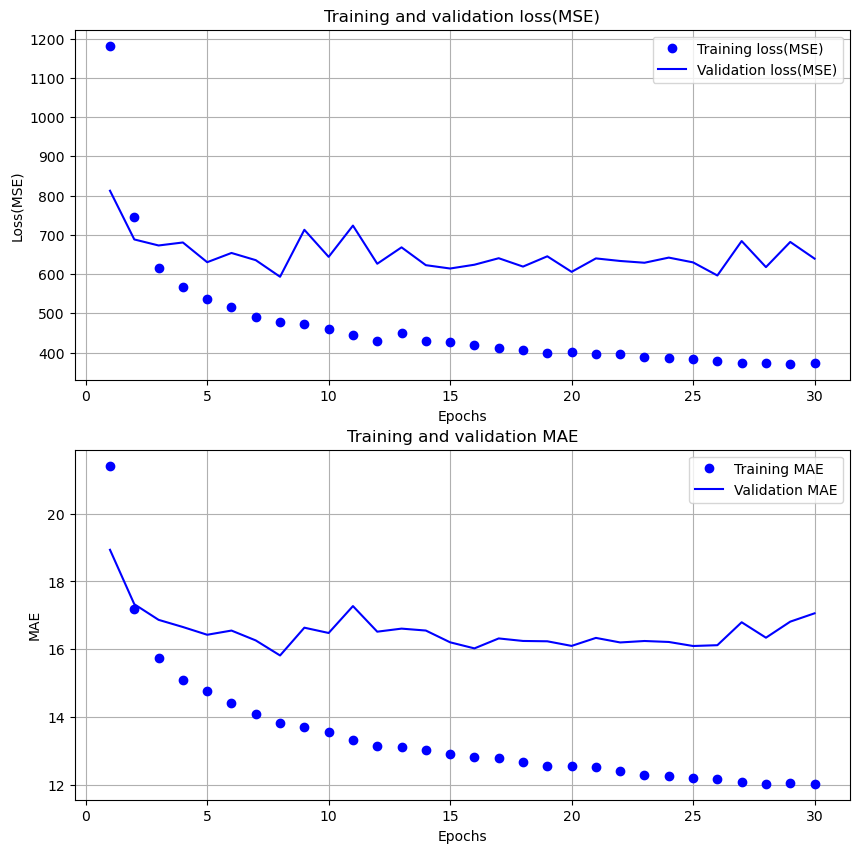

In [ ]:
plot_history(history)

Epoch 1/50
2003/2003 [==============================] - 7s 4ms/step - loss: 369.2269 - mae: 11.9876 - val_loss: 610.5648 - val_mae: 16.1064
Epoch 2/50
2003/2003 [==============================] - 7s 4ms/step - loss: 374.5306 - mae: 12.0610 - val_loss: 603.1572 - val_mae: 15.9551
Epoch 3/50
2003/2003 [==============================] - 7s 3ms/step - loss: 362.5941 - mae: 11.9388 - val_loss: 596.4218 - val_mae: 16.1503
Epoch 4/50
2003/2003 [==============================] - 7s 3ms/step - loss: 362.7232 - mae: 11.8799 - val_loss: 600.1092 - val_mae: 16.0046
Epoch 5/50
2003/2003 [==============================] - 7s 3ms/step - loss: 358.2141 - mae: 11.8639 - val_loss: 609.0306 - val_mae: 16.3286
Epoch 6/50
2003/2003 [==============================] - 7s 3ms/step - loss: 360.1147 - mae: 11.8565 - val_loss: 581.7192 - val_mae: 15.9737
Epoch 7/50
2003/2003 [==============================] - 7s 3ms/step - loss: 363.6921 - mae: 11.9037 - val_loss: 609.7076 - val_mae: 16.0646
Epoch 8/50
2003/2003

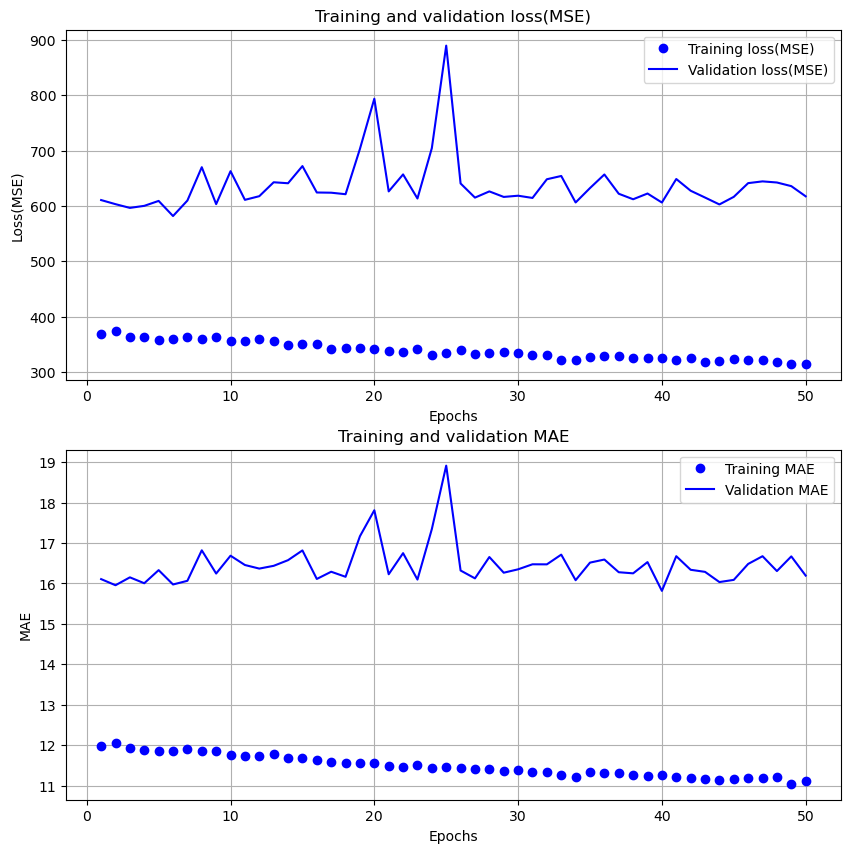

In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2 ,epochs=50,
                    batch_size=64, callbacks=callbacks)
plot_history(history)


Epoch 1/100
2003/2003 [==============================] - 19s 10ms/step - loss: 312.5428 - mae: 11.0647 - val_loss: 595.3114 - val_mae: 16.0422
Epoch 2/100
2003/2003 [==============================] - 18s 9ms/step - loss: 318.3294 - mae: 11.1401 - val_loss: 615.2719 - val_mae: 16.3026
Epoch 3/100
2003/2003 [==============================] - 16s 8ms/step - loss: 314.7582 - mae: 11.0737 - val_loss: 726.7863 - val_mae: 17.4969
Epoch 4/100
2003/2003 [==============================] - 17s 8ms/step - loss: 314.6398 - mae: 11.1336 - val_loss: 627.6340 - val_mae: 16.4975
Epoch 5/100
2003/2003 [==============================] - 16s 8ms/step - loss: 310.0984 - mae: 11.0479 - val_loss: 640.9551 - val_mae: 16.7662
Epoch 6/100
2003/2003 [==============================] - 16s 8ms/step - loss: 312.7509 - mae: 11.0922 - val_loss: 617.5994 - val_mae: 16.2560
Epoch 7/100
2003/2003 [==============================] - 14s 7ms/step - loss: 307.5193 - mae: 10.9666 - val_loss: 635.1392 - val_mae: 16.6012
Epoch

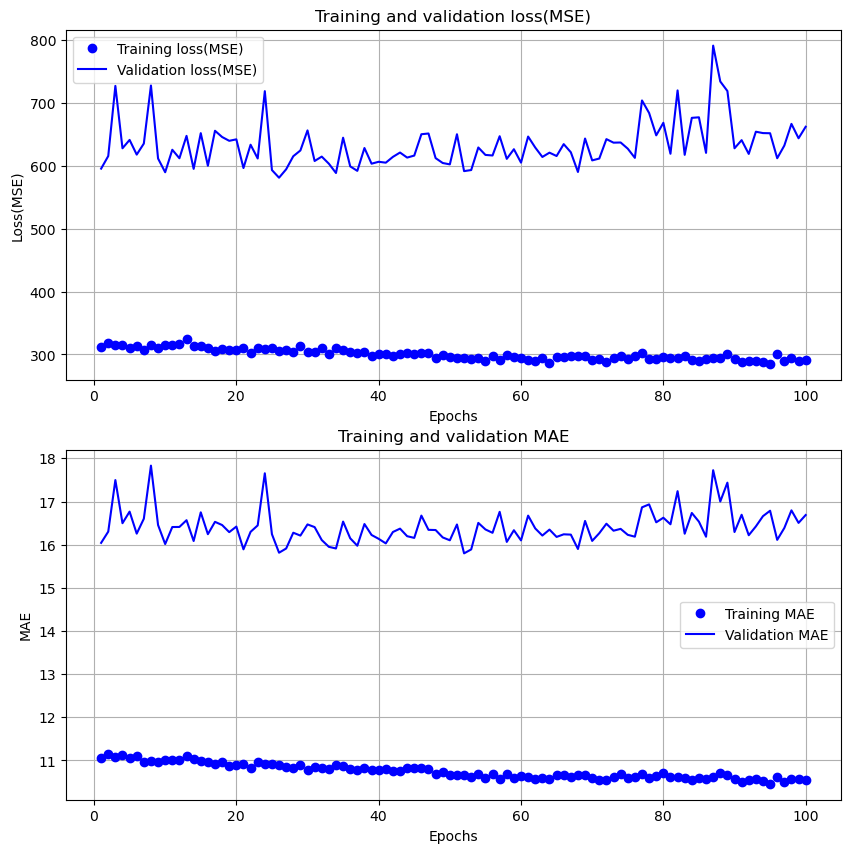

In [ ]:
history = model.fit(train_data, train_targets, validation_split=0.2,
                    batch_size=64, callbacks=callbacks)

plot_history(history)


## Preprocessing the test data